# Getting Tables Out of PDFs

Tables in PDFs can be a real pain. Sometimes they're perfectly formatted with nice lines, other times they're just text floating around that vaguely looks like a table. Natural PDF gives you several different approaches to tackle whatever table nightmare you're dealing with.

## Setup

Let's start with a PDF that has some tables to work with.

CropBox missing from /Page, defaulting to MediaBox


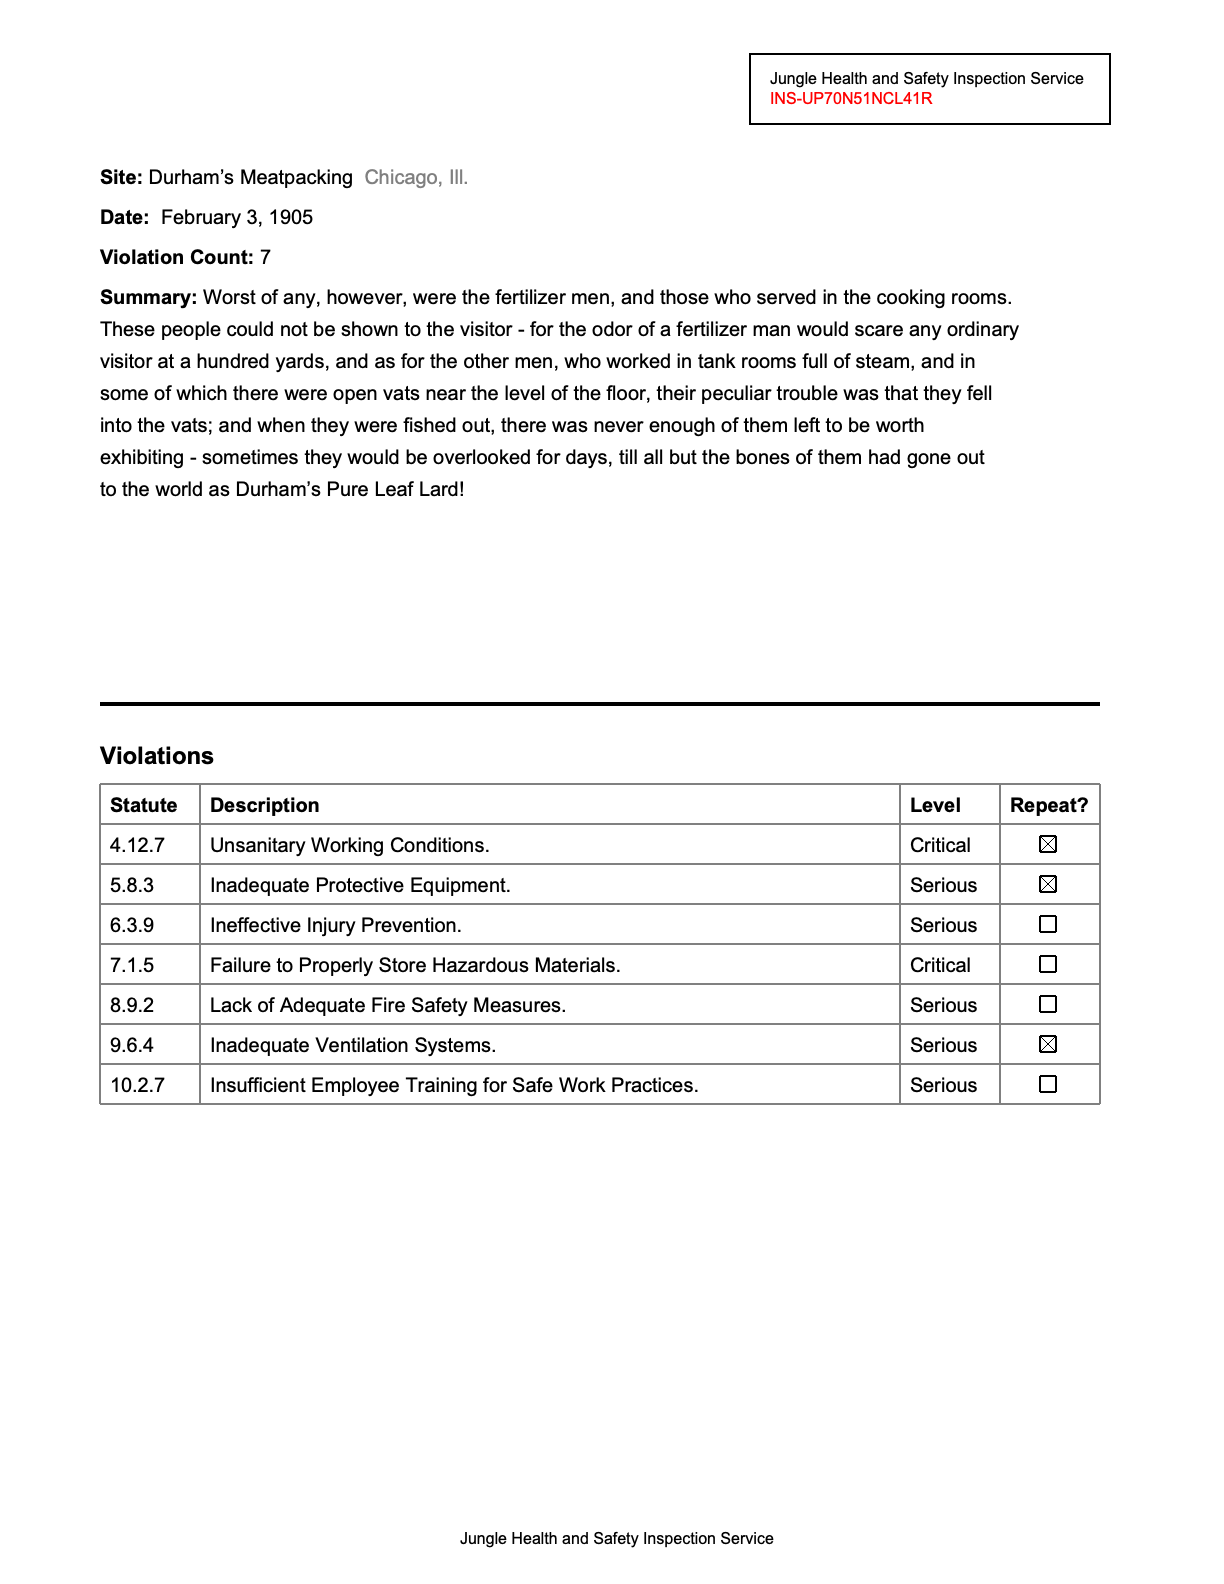

In [1]:
from natural_pdf import PDF

# Load the PDF
pdf = PDF("https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/01-practice.pdf")

# Select the first page
page = pdf.pages[0]

# Display the page
page.show()

## The Quick and Dirty Approach

If you know there's a table somewhere and just want to try extracting it, start simple:

In [2]:
# Try to extract the first table found on the page
# This uses pdfplumber behind the scenes
table_data = page.extract_table() # Returns a list of lists
table_data

TableResult(rows=8…)

*This might work great, or it might give you garbage. Tables are tricky.*

## The Smart Way: Detect First, Then Extract

A better approach is to first find where the tables actually are, then extract them properly.

### Finding Tables with YOLO (Fast and Pretty Good)

The YOLO model is good at spotting table-shaped areas on a page.

image 1/1 /var/folders/25/h3prywj14qb0mlkl2s8bxq5m0000gn/T/tmps28iifoq/temp_layout_image.png: 1024x800 1 title, 3 plain texts, 2 abandons, 1 table, 695.2ms


Speed: 5.1ms preprocess, 695.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)


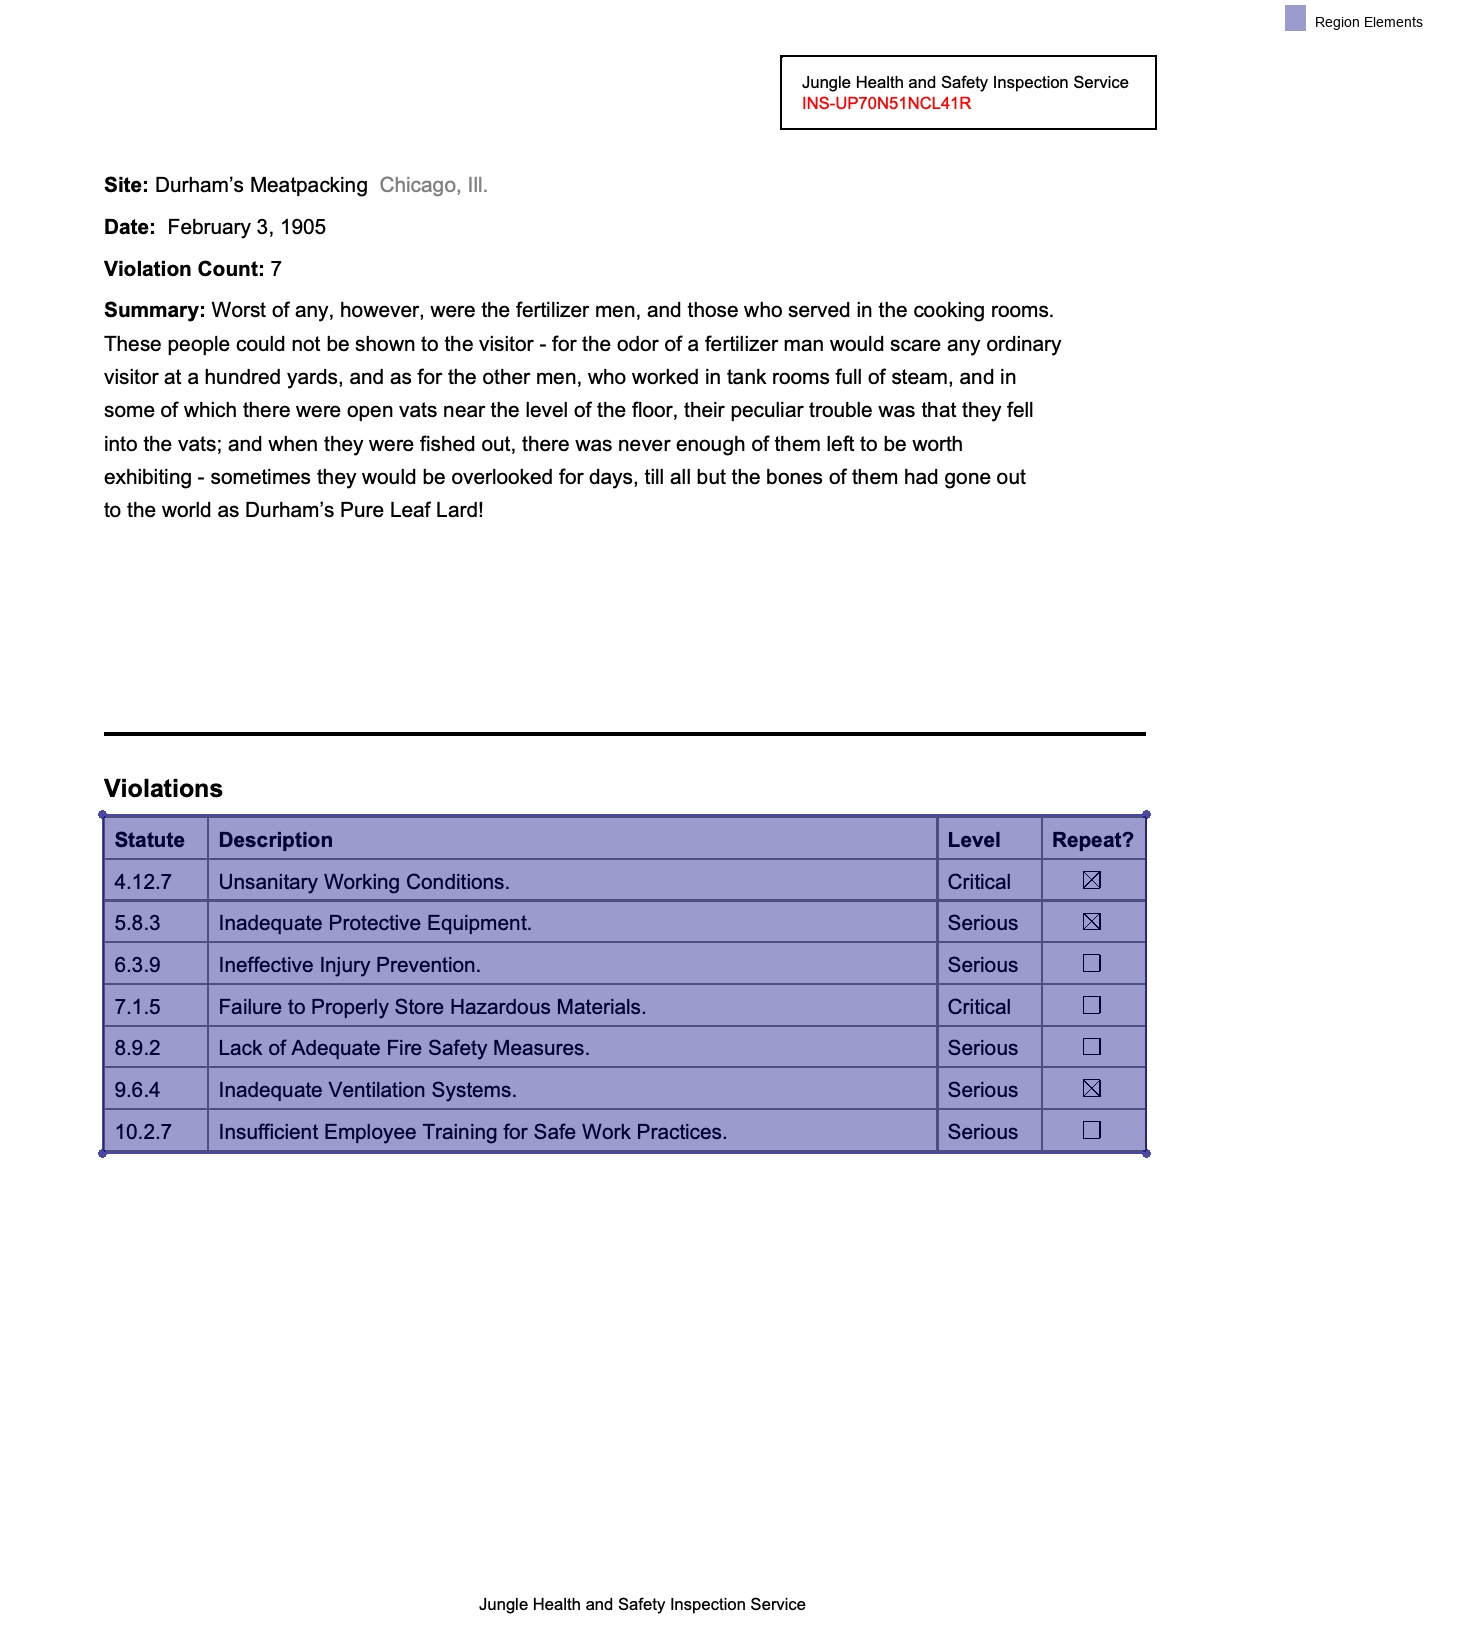

In [3]:
# Use YOLO to find table regions
page.analyze_layout(engine='yolo')

# Find what it thinks are tables
table_regions_yolo = page.find_all('region[type=table][model=yolo]')
table_regions_yolo.show()

In [4]:
# Extract data from the detected table
table_regions_yolo[0].extract_table()

TableResult(rows=8…)

### Finding Tables with TATR (Slow but Very Smart)

The TATR model actually understands table structure - it can tell you where rows, columns, and headers are.

In [5]:
# Clear previous results and try TATR
page.clear_detected_layout_regions() 
page.analyze_layout(engine='tatr')

<ElementCollection[Region](count=15)>

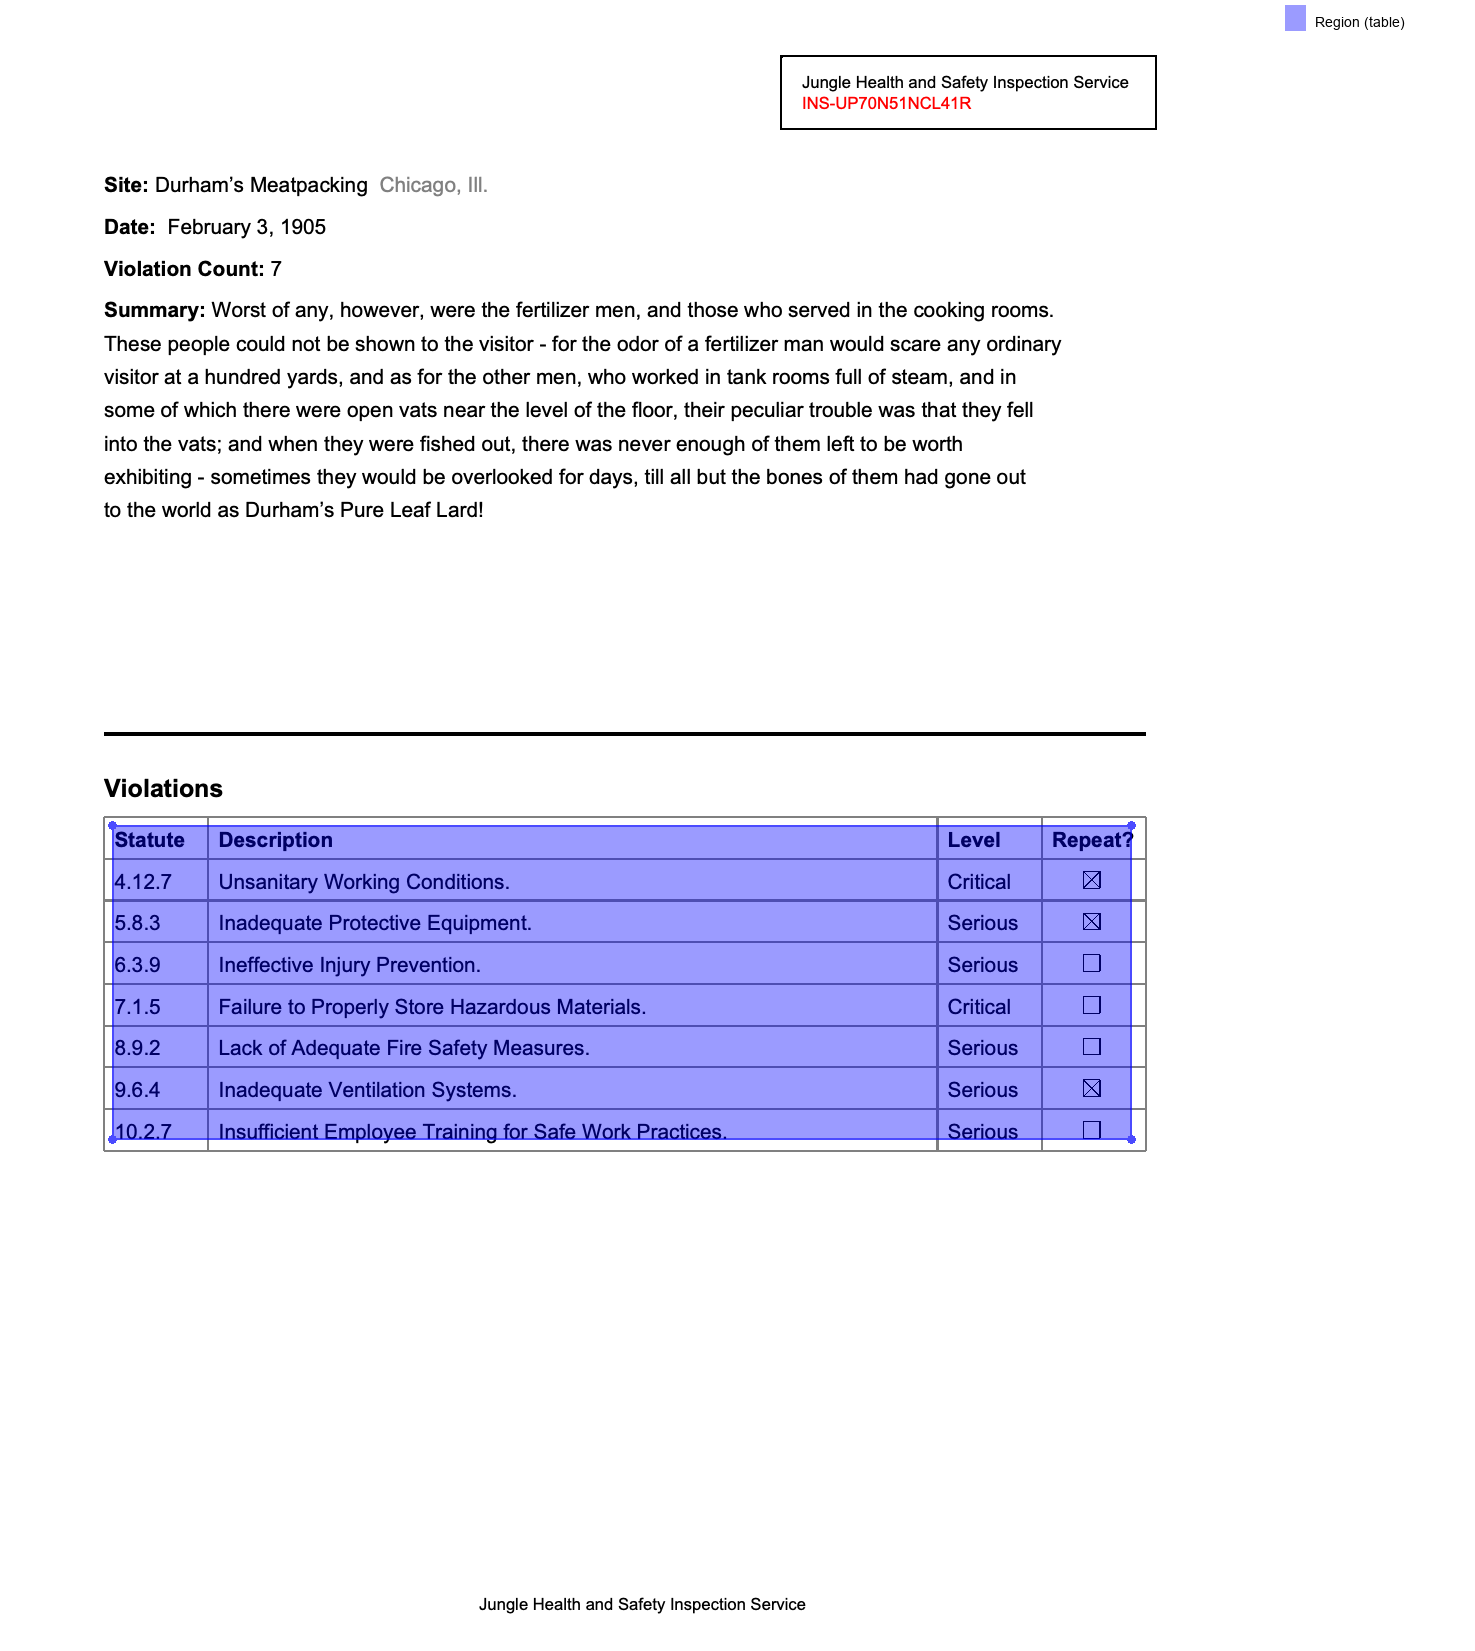

In [6]:
# Find the table that TATR detected
tatr_table = page.find('region[type=table][model=tatr]')
tatr_table.show()

In [7]:
# TATR finds the internal structure too
rows = page.find_all('region[type=table-row][model=tatr]')
cols = page.find_all('region[type=table-column][model=tatr]')
hdrs = page.find_all('region[type=table-column-header][model=tatr]')
f"TATR found: {len(rows)} rows, {len(cols)} columns, {len(hdrs)} headers"

'TATR found: 8 rows, 4 columns, 1 headers'

## Choosing Your Extraction Method

When you call `extract_table()` on a detected region, Natural PDF picks the extraction method automatically:
- **YOLO-detected regions** → uses `pdfplumber` (looks for lines and text alignment)
- **TATR-detected regions** → uses the smart `tatr` method (uses the detected structure)

You can override this if needed:

In [8]:
tatr_table = page.find('region[type=table][model=tatr]')
# Use TATR's smart extraction
tatr_table.extract_table(method='tatr')

TableResult(rows=9…)

In [9]:
# Or force it to use pdfplumber instead (maybe for comparison)
tatr_table.extract_table(method='pdfplumber')

TableResult(rows=6…)

### When to Use Which?

- **`pdfplumber`**: Great for clean tables with visible grid lines. Fast and reliable.
- **`tatr`**: Better for messy tables, tables without lines, or tables with merged cells. Slower but smarter.

## When Tables Don't Cooperate

Sometimes the automatic detection doesn't work well. You can tweak pdfplumber's settings:

In [10]:
# Custom settings for tricky tables
table_settings = {
    "vertical_strategy": "text",      # Use text alignment instead of lines
    "horizontal_strategy": "lines",   # Still use lines for rows
    "intersection_x_tolerance": 5,    # Be more forgiving about line intersections
}

results = page.extract_table(table_settings=table_settings)

## Manual Table Structure with Guides

When automatic detection fails completely, you can manually define table structure using the **Guides API**. This is perfect for scanned documents, forms, or when you need precise control over table boundaries.

### What are Guides?

Guides are visual alignment lines - think of them like the rulers in a design program. You can place them manually or detect them automatically, then use them to build perfect table grids.

CropBox missing from /Page, defaulting to MediaBox


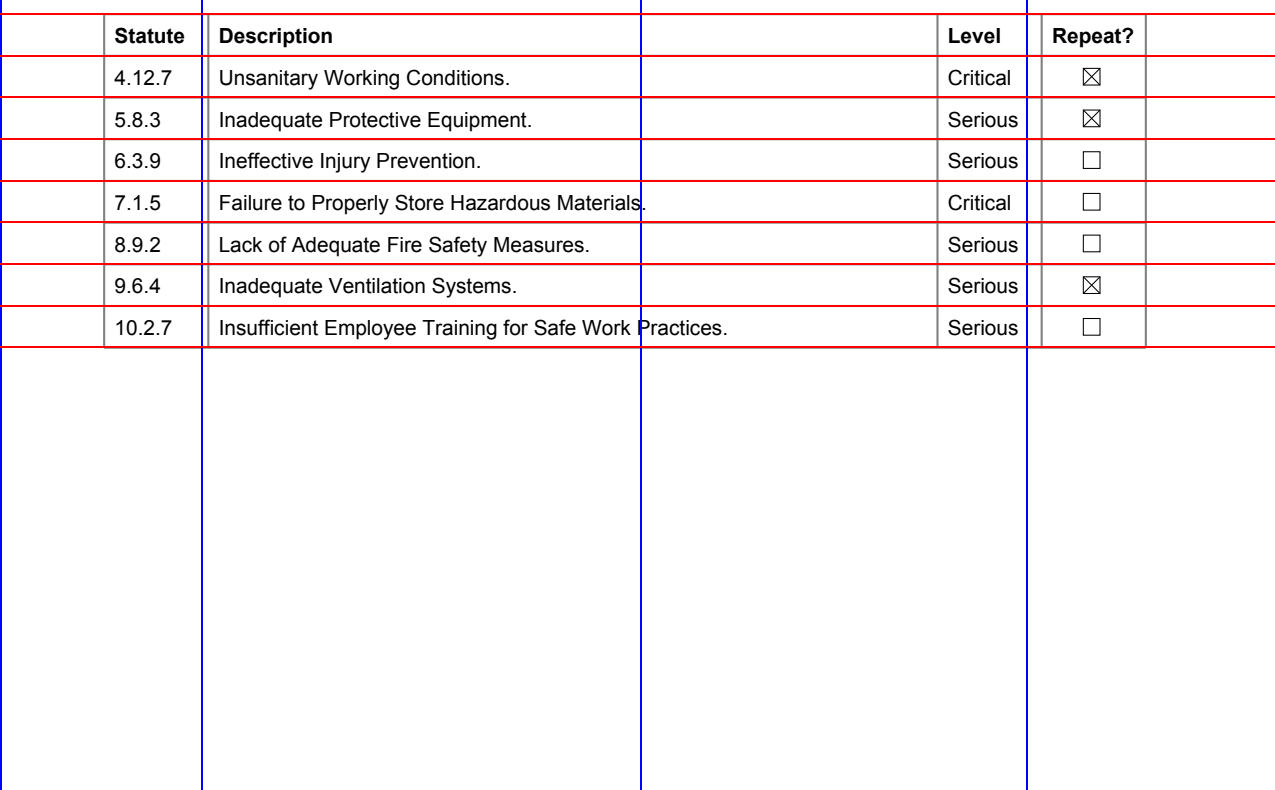

In [11]:
from natural_pdf import PDF
from natural_pdf.analyzers import Guides

# Load the PDF
pdf = PDF("https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/01-practice.pdf")

# Select the first page
page = pdf.pages[0]

region = (
    page
    .find('text:contains(Violations)')
    .below(
        until='text[size<10]',
        include_endpoint=False
    )
)

# Create guides for a page
guides = Guides(region)

# Create horizontal guides between rows
guides.vertical.from_content(
    markers=region.find_all("text[size=10]:bold"),  # Use CSS selectors to find row content
    align='between'
)

# Create horizontal guides by finding visual lines
guides.horizontal.from_lines()

guides.show()

But it doesn't line up well!! So we can adjust it to snap to the whitespace between the text.

In [12]:
guides.vertical.snap_to_whitespace(detection_method='text')

Guides(verticals=5, horizontals=9, cells=32)

### Creating Guides from Content

The smartest way is to create guides based on the actual content on the page:

In [13]:
# Create vertical guides between columns by finding content gaps
guides.vertical.from_content(
    markers=['Statute', 'Description', 'Level' ,'Repeat'],  # Look for column headers
    align='between'  # Place guides between columns, not on them
)

# You can also use a single selector or ElementCollection
guides.vertical.from_content(
    markers="text[size=10]:bold",  # Single selector
    align='after'
)

# Or pass an ElementCollection directly
headers = page.find_all('text:bold')
guides.horizontal.from_content(
    markers=headers,  # ElementCollection of elements
    align='center'
)

Guides(verticals=2, horizontals=3, cells=2)

### Manual Guide Placement

For maximum control, place guides manually:

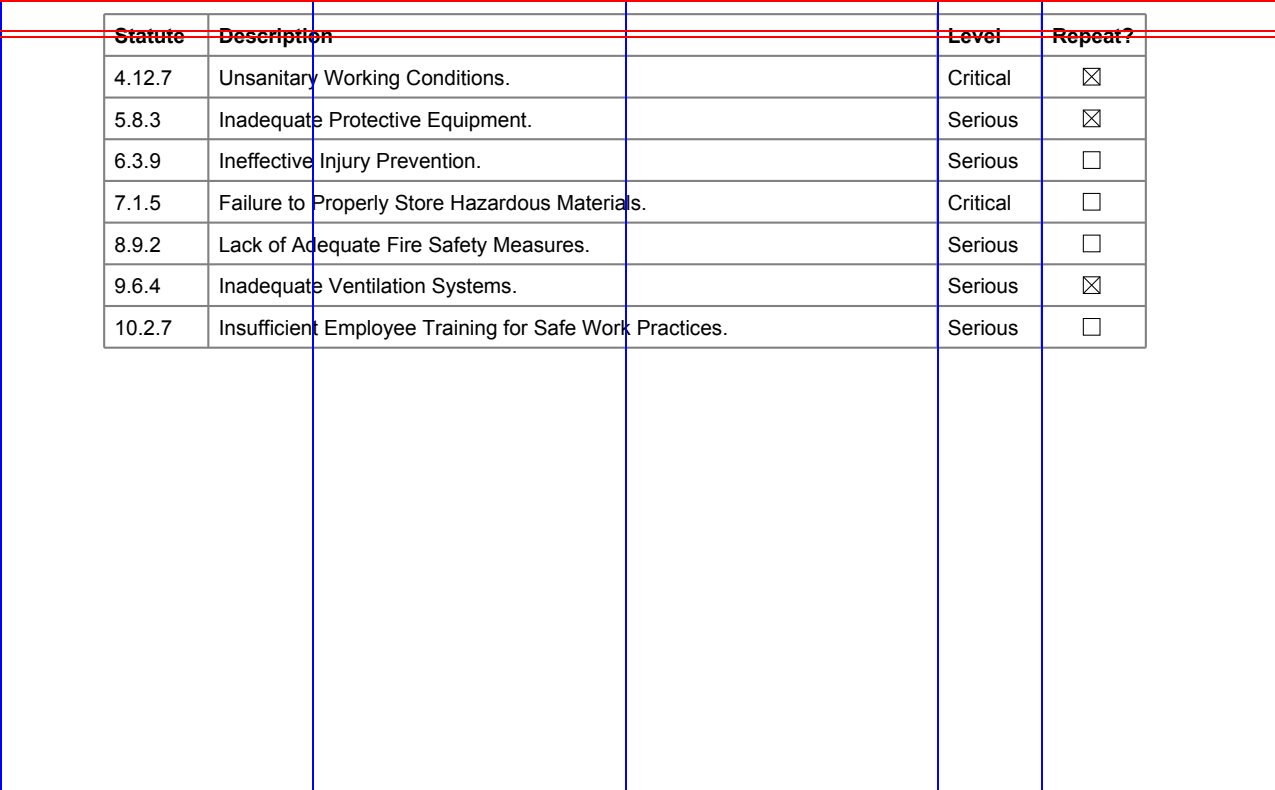

In [14]:
# Place guides at specific coordinates
guides.vertical.add([150, 300, 450])  # x-coordinates (list)
guides.horizontal.add([200, 250, 300, 350])  # y-coordinates (list)

# Or add them one at a time
guides.vertical.add(500)  # single x-coordinate
guides.horizontal.add(400)  # single y-coordinate

guides.show()

### Fine-tuning Guide Positions

Guides have smart methods for adjusting positions:

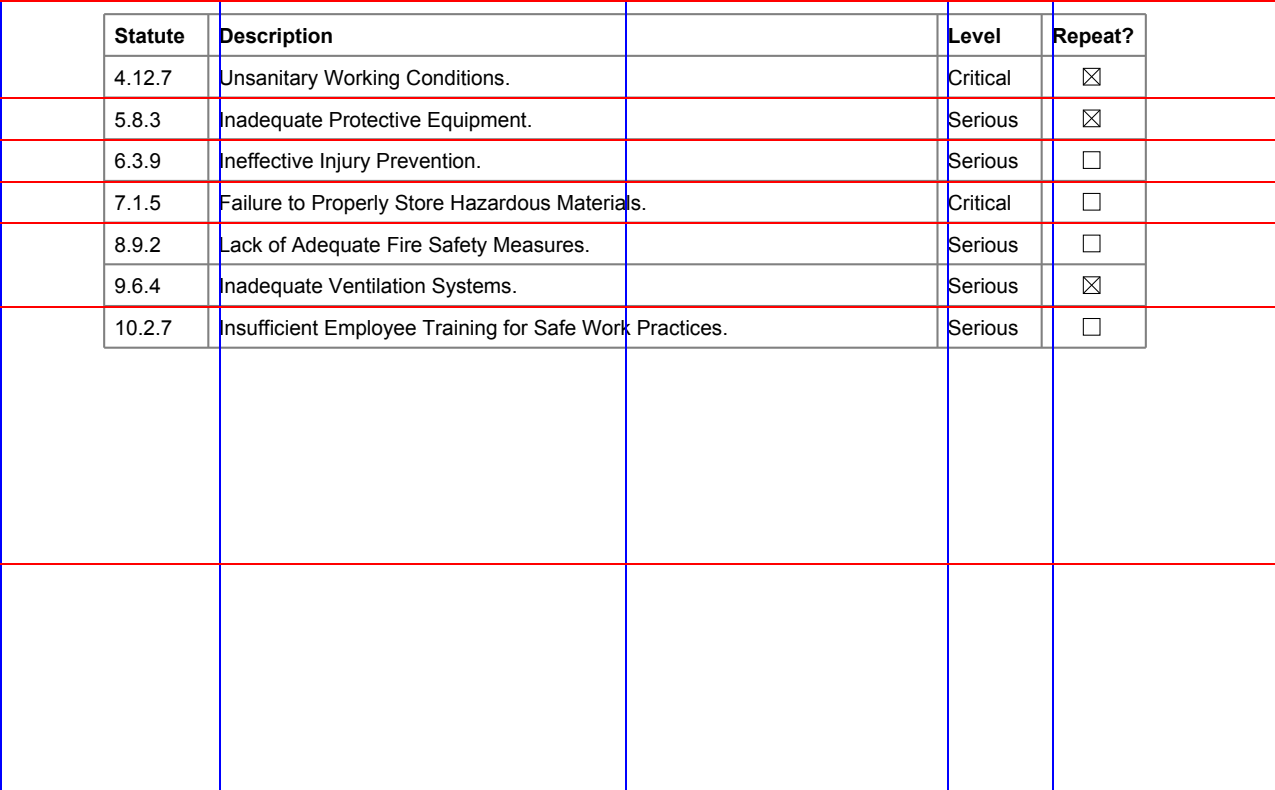

In [15]:
# Snap guides to whitespace gaps for cleaner alignment
guides.vertical.snap_to_whitespace()
guides.horizontal.snap_to_whitespace()

# Snap guides to content boundaries
guides.vertical.snap_to_content()

# Manually adjust specific guides
guides.vertical.shift(index=1, offset=10)  # Move second guide 10 points right

guides.show()

### Building Tables from Guides

Once your guides are positioned correctly, build the table structure:

In [16]:
# Create guides for a page
guides = Guides(region)

# Create horizontal guides between rows
guides.vertical.from_content(
    markers=region.find_all("text[size=10]:bold"),  # Use CSS selectors to find row content
    align='between'
)

# Create horizontal guides by finding visual lines
guides.horizontal.from_lines()

# Create table, row, column, and cell regions
grid_info = guides.build_grid(source='manual')

# See what was created
print(f"Created: {grid_info}")
# Output: {'table': 1, 'rows': 3, 'columns': 4, 'cells': 12}

Created: {'counts': {'table': 1, 'rows': 8, 'columns': 4, 'cells': 32}, 'regions': {'table': <Region type='table' source='manual' bbox=(0.0, 392.0, 612.0, 552.0)>, 'rows': [<Region type='table_row' source='manual' bbox=(0.0, 392.0, 612.0, 412.0)>, <Region type='table_row' source='manual' bbox=(0.0, 412.0, 612.0, 432.0)>, <Region type='table_row' source='manual' bbox=(0.0, 432.0, 612.0, 452.0)>, <Region type='table_row' source='manual' bbox=(0.0, 452.0, 612.0, 472.0)>, <Region type='table_row' source='manual' bbox=(0.0, 472.0, 612.0, 492.0)>, <Region type='table_row' source='manual' bbox=(0.0, 492.0, 612.0, 512.0)>, <Region type='table_row' source='manual' bbox=(0.0, 512.0, 612.0, 532.0)>, <Region type='table_row' source='manual' bbox=(0.0, 532.0, 612.0, 552.0)>], 'columns': [<Region type='table_column' source='manual' bbox=(0.0, 392.0, 96.945, 552.0)>, <Region type='table_column' source='manual' bbox=(96.945, 392.0, 307.505, 552.0)>, <Region type='table_column' source='manual' bbox=(30

### Extracting Data from Guide-Based Tables

The magic happens here - `extract_table()` automatically detects your guide-based table structure:

In [17]:
# Find the table you just created
table = page.find('table[source=manual]')

# Extract data - this uses the cell regions you built!
table_data = table.extract_table()
table_data.to_df()

,Statute,Description,Level,Repeat?
0,4.12.7,Unsanitary Working Conditions.,Critical,None
1,5.8.3,Inadequate Protective Equipment.,Serious,None
2,6.3.9,Ineffective Injury Prevention.,Serious,None
3,7.1.5,Failure to Properly Store Hazardous Materials,. Critical,None
4,8.9.2,Lack of Adequate Fire Safety Measures.,Serious,None
5,9.6.4,Inadequate Ventilation Systems.,Serious,None
6,10.2.7,Insufficient Employee Training for Safe Work P,Practices. Serious,None


### Pro Tips for Guides

- **Preview everything**: Use `guides.show()` liberally to check your work
- **Use content-based creation**: `from_content()` is usually smarter than manual placement
- **Snap to clean up**: The `snap_to_*` methods fix small alignment issues
- **Label your work**: Use descriptive `source` labels to keep track of different table attempts

### Creating Guides from Lines

The most accurate method is to use existing lines in the PDF (if they exist) or detect them from the image:

In [18]:
# Method 1: Use existing vector lines in the PDF
page.detect_lines(source_label='my_lines')  # First detect lines if not already done
guides.vertical.from_lines(source='my_lines')
guides.horizontal.from_lines(source='my_lines')

# Method 2: Detect lines directly from pixels (no pre-detection needed!)
guides.vertical.from_lines(detection_method='pixels', max_lines=5)
guides.horizontal.from_lines(detection_method='pixels', threshold=0.3)

# Method 3: Create all guides at once with pixel detection
guides = Guides.from_lines(
    page,
    detection_method='pixels',
    threshold='auto',  # Automatically find threshold
    max_lines_h=4,     # Find up to 4 horizontal lines
    max_lines_v=3      # Find up to 3 vertical lines
)

# Additional parameters for pixel detection
guides = Guides.from_lines(
    page,
    detection_method='pixels',
    resolution=192,              # DPI for rasterization
    min_gap_h=10,               # Minimum gap between horizontal lines
    min_gap_v=15,               # Minimum gap between vertical lines  
    binarization_method='adaptive',  # or 'otsu'
    method='projection'          # or 'lsd' (requires opencv)
)

## Working with the result: `TableResult`

`extract_table()` returns a **`TableResult`** object – it behaves like
a regular list of rows *and* offers two convenience shortcuts:

In [19]:
tbl = page.extract_table()

# Grab it as a dataframe
# Shortcut for .to_df() because it's so many letters
tbl.df

,Statute,Description,Level,Repeat?
0,4.12.7,Unsanitary Working Conditions.,Critical,None
1,5.8.3,Inadequate Protective Equipment.,Serious,None
2,6.3.9,Ineffective Injury Prevention.,Serious,None
3,7.1.5,Failure to Properly Store Hazardous Materials,. Critical,None
4,8.9.2,Lack of Adequate Fire Safety Measures.,Serious,None
5,9.6.4,Inadequate Ventilation Systems.,Serious,None
6,10.2.7,Insufficient Employee Training for Safe Work P,Practices. Serious,None


In [20]:
# First row is NOT headers
tbl.to_df(header=None)

,0,1,2,3
0,Statute,Description,Level,Repeat?
1,4.12.7,Unsanitary Working Conditions.,Critical,None
2,5.8.3,Inadequate Protective Equipment.,Serious,None
3,6.3.9,Ineffective Injury Prevention.,Serious,None
4,7.1.5,Failure to Properly Store Hazardous Materials,. Critical,None
5,8.9.2,Lack of Adequate Fire Safety Measures.,Serious,None
6,9.6.4,Inadequate Ventilation Systems.,Serious,None
7,10.2.7,Insufficient Employee Training for Safe Work P,Practices. Serious,None


### Stitching rows across page breaks (multi-page tables)

If your table spans **multiple pages** you might find that the first row on a
continuation page actually belongs to the last row on the previous page (for
example when the bottom border of the table is repeated but the first column
on the new page is blank).  `extract_table()` has a simple fix for this:

```py
# Create a Flow from all pages that make up the table
flow = pdf.pages[1:4].as_flow(arrangement="vertical")

# Provide a rule (prev_row, cur_row, row_idx, segment) -> bool
merge_if_first_cell_empty = lambda prev, cur, i, seg: i == 0 and not cur[0]

data = flow.extract_table(stitch_rows=merge_if_first_cell_empty)
```

`stitch_rows` is **optional** – if you leave it out, extraction behaves exactly
as before.  Pass a callable predicate to decide, row-by-row, whether a row should be spliced into the previous one.  The same
parameter is available on `FlowRegion.extract_table()`.

## Next Steps

Tables are just one part of document structure. Once you've got table extraction working:

- [Layout Analysis](../layout-analysis/index.ipynb): See how table detection fits into understanding the whole document
- [Working with Regions](../regions/index.ipynb): Manually define table areas when automatic detection fails